<a href="https://colab.research.google.com/github/berberberk/timl-ss-2025/blob/main/TIML1_FCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import f1_score

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Используемое устройство:", device)

Используемое устройство: cpu


In [ ]:
class FCNN(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, activation='relu', dropout_prob=0.0):
        """
        input_dim: размер входного вектора (например, 784)
        hidden_dims: список с количеством нейронов в каждом скрытом слое
        output_dim: число классов (например, 10)
        activation: тип функции активации ('relu', 'sigmoid', 'tanh')
        dropout_prob: вероятность зануления нейронов (0.0 = не используется)
        """
        super(FCNN, self).__init__()
        layers = []
        last_dim = input_dim

        # Добавляем скрытые слои
        for h_dim in hidden_dims:
            layers.append(nn.Linear(last_dim, h_dim))
            if activation.lower() == 'relu':
                layers.append(nn.ReLU())
            elif activation.lower() == 'sigmoid':
                layers.append(nn.Sigmoid())
            elif activation.lower() == 'tanh':
                layers.append(nn.Tanh())
            else:
                raise ValueError("Не поддерживается функция активации {}".format(activation))
            if dropout_prob > 0.0:
                layers.append(nn.Dropout(dropout_prob))
            last_dim = h_dim

        # Выходной слой (без softmax – CrossEntropyLoss работает с логитами)
        layers.append(nn.Linear(last_dim, output_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

In [ ]:
def train_one_epoch(model, data_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in data_loader:
        # Преобразуем изображения в векторы
        inputs = inputs.view(inputs.size(0), -1).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        # Вычисляем количество верных ответов
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def evaluate(model, data_loader, criterion, device, return_preds=False):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.view(inputs.size(0), -1).to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if return_preds:
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    if return_preds:
        return epoch_loss, epoch_acc, np.array(all_preds), np.array(all_labels)
    else:
        return epoch_loss, epoch_acc

In [ ]:

def plot_metrics(train_metrics, test_metrics, ylabel, title):
    epochs = range(1, len(train_metrics)+1)
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_metrics, 'bo-', label='Обучение')
    plt.plot(epochs, test_metrics, 'ro-', label='Тест')
    plt.title(title)
    plt.xlabel("Эпоха")
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid()
    plt.show()

def plot_misclassified(model, data_loader, device, num_images=12):
    model.eval()
    misclassified_imgs = []
    misclassified_preds = []
    misclassified_labels = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs_flat = inputs.view(inputs.size(0), -1).to(device)
            outputs = model(inputs_flat)
            _, predicted = torch.max(outputs, 1)
            # Найдём неверно классифицированные примеры
            for img, pred, true in zip(inputs.cpu(), predicted.cpu(), labels):
                if pred != true:
                    misclassified_imgs.append(img.squeeze())
                    misclassified_preds.append(pred.item())
                    misclassified_labels.append(true.item())
                if len(misclassified_imgs) >= num_images:
                    break
            if len(misclassified_imgs) >= num_images:
                break

    if misclassified_imgs:
        plt.figure(figsize=(10, 4))
        for i, (img, pred, true) in enumerate(zip(misclassified_imgs, misclassified_preds, misclassified_labels)):
            plt.subplot(3, num_images//3, i+1)
            plt.imshow(img, cmap='gray')
            plt.title(f"pred: {pred}\ntrue: {true}")
            plt.axis('off')
        plt.tight_layout()
        plt.show()
    else:
        print("Нет неверно классифицированных изображений для отображения.")

In [ ]:
num_epochs = 10
batch_size = 64
learning_rate = 0.001


#############################################
# Часть 1. Работа с MNIST
#############################################

In [ ]:
# Определяем преобразования: преобразование в тензор и нормализация
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [ ]:
# Загрузка датасета MNIST
train_dataset_mnist = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset_mnist = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader_mnist = torch.utils.data.DataLoader(train_dataset_mnist, batch_size=batch_size, shuffle=True)
test_loader_mnist = torch.utils.data.DataLoader(test_dataset_mnist, batch_size=batch_size, shuffle=False)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:02<00:00, 4.76MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 155kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.45MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.39MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Обучение на MNIST...
Эпоха 1/10: Train loss=0.3962, Train acc=0.8829 | Test loss=0.2121, Test acc=0.9378
Эпоха 2/10: Train loss=0.1877, Train acc=0.9433 | Test loss=0.1582, Test acc=0.9511
Эпоха 3/10: Train loss=0.1350, Train acc=0.9589 | Test loss=0.1250, Test acc=0.9631
Эпоха 4/10: Train loss=0.1108, Train acc=0.9659 | Test loss=0.1020, Test acc=0.9697
Эпоха 5/10: Train loss=0.0902, Train acc=0.9724 | Test loss=0.1089, Test acc=0.9672
Эпоха 6/10: Train loss=0.0785, Train acc=0.9756 | Test loss=0.1006, Test acc=0.9698
Эпоха 7/10: Train loss=0.0722, Train acc=0.9771 | Test loss=0.1088, Test acc=0.9674
Эпоха 8/10: Train loss=0.0662, Train acc=0.9784 | Test loss=0.0846, Test acc=0.9735
Эпоха 9/10: Train loss=0.0587, Train acc=0.9816 | Test loss=0.0877, Test acc=0.9724
Эпоха 10/10: Train loss=0.0528, Train acc=0.9825 | Test loss=0.0956, Test acc=0.9717


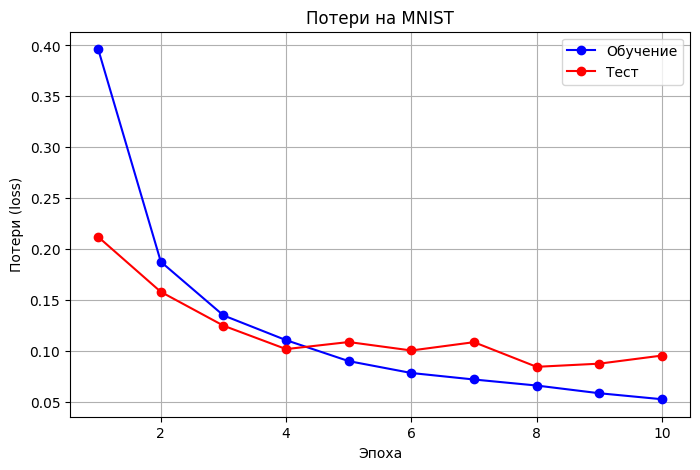

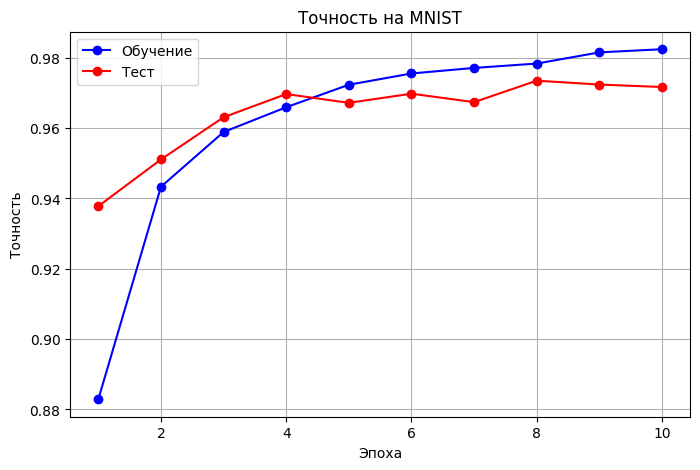

Визуализация ошибок на MNIST:


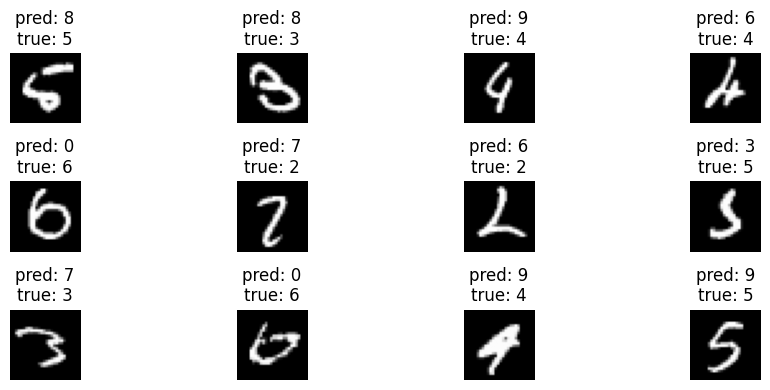

In [ ]:
# Создаем модель для MNIST: два скрытых слоя (128 и 64 нейрона), функция активации ReLU, без Dropout
model_mnist = FCNN(input_dim=28*28, hidden_dims=[128, 64], output_dim=10, activation='relu', dropout_prob=0.0).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_mnist.parameters(), lr=learning_rate)

train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

print("Обучение на MNIST...")
for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model_mnist, train_loader_mnist, criterion, optimizer, device)
    test_loss, test_acc = evaluate(model_mnist, test_loader_mnist, criterion, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)
    print(f"Эпоха {epoch+1}/{num_epochs}: Train loss={train_loss:.4f}, Train acc={train_acc:.4f} | Test loss={test_loss:.4f}, Test acc={test_acc:.4f}")

# Графики для MNIST
plot_metrics(train_losses, test_losses, ylabel="Потери (loss)", title="Потери на MNIST")
plot_metrics(train_accuracies, test_accuracies, ylabel="Точность", title="Точность на MNIST")

# Визуализация неверно классифицированных изображений
print("Визуализация ошибок на MNIST:")
plot_misclassified(model_mnist, test_loader_mnist, device, num_images=12)

#############################################
# Часть 2. Работа с KMNIST
#############################################

In [ ]:
# Загрузка датасета KMNIST
train_dataset_kmnist = torchvision.datasets.KMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset_kmnist = torchvision.datasets.KMNIST(root='./data', train=False, download=True, transform=transform)

train_loader_kmnist = torch.utils.data.DataLoader(train_dataset_kmnist, batch_size=batch_size, shuffle=True)
test_loader_kmnist = torch.utils.data.DataLoader(test_dataset_kmnist, batch_size=batch_size, shuffle=False)

100%|██████████| 18.2M/18.2M [00:06<00:00, 2.70MB/s]


Extracting ./data/KMNIST/raw/train-images-idx3-ubyte.gz to ./data/KMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 458kB/s]


Extracting ./data/KMNIST/raw/train-labels-idx1-ubyte.gz to ./data/KMNIST/raw



100%|██████████| 3.04M/3.04M [00:01<00:00, 3.00MB/s]


Extracting ./data/KMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/KMNIST/raw



100%|██████████| 5.12k/5.12k [00:00<00:00, 4.79MB/s]

Extracting ./data/KMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/KMNIST/raw



In [ ]:
# Определим два эксперимента: с dropout и без dropout.
experiments = [
    {"name": "Без Dropout, ReLU, hidden=[256, 128]", "hidden_dims": [256, 128], "activation": "relu", "dropout": 0.0},
    {"name": "С Dropout(0.5), ReLU, hidden=[256, 128]", "hidden_dims": [256, 128], "activation": "relu", "dropout": 0.5},
    # Можно добавить и эксперименты с Sigmoid и Tanh
    {"name": "Без Dropout, Sigmoid, hidden=[256, 128]", "hidden_dims": [256, 128], "activation": "sigmoid", "dropout": 0.0},
    {"name": "Без Dropout, Tanh, hidden=[256, 128]", "hidden_dims": [256, 128], "activation": "tanh", "dropout": 0.0},
]


--- Эксперимент: Без Dropout, ReLU, hidden=[256, 128] ---
Эпоха 1/10: Train loss=0.4329, Train acc=0.8659 | Test loss=0.5427, Test acc=0.8307
Эпоха 2/10: Train loss=0.2064, Train acc=0.9366 | Test loss=0.4828, Test acc=0.8582
Эпоха 3/10: Train loss=0.1452, Train acc=0.9540 | Test loss=0.4353, Test acc=0.8751
Эпоха 4/10: Train loss=0.1135, Train acc=0.9643 | Test loss=0.3934, Test acc=0.8916
Эпоха 5/10: Train loss=0.0902, Train acc=0.9714 | Test loss=0.3924, Test acc=0.8953
Эпоха 6/10: Train loss=0.0779, Train acc=0.9746 | Test loss=0.4588, Test acc=0.8902
Эпоха 7/10: Train loss=0.0653, Train acc=0.9787 | Test loss=0.4002, Test acc=0.9038
Эпоха 8/10: Train loss=0.0556, Train acc=0.9820 | Test loss=0.4599, Test acc=0.9009
Эпоха 9/10: Train loss=0.0468, Train acc=0.9844 | Test loss=0.4881, Test acc=0.8931
Эпоха 10/10: Train loss=0.0449, Train acc=0.9852 | Test loss=0.4781, Test acc=0.9037


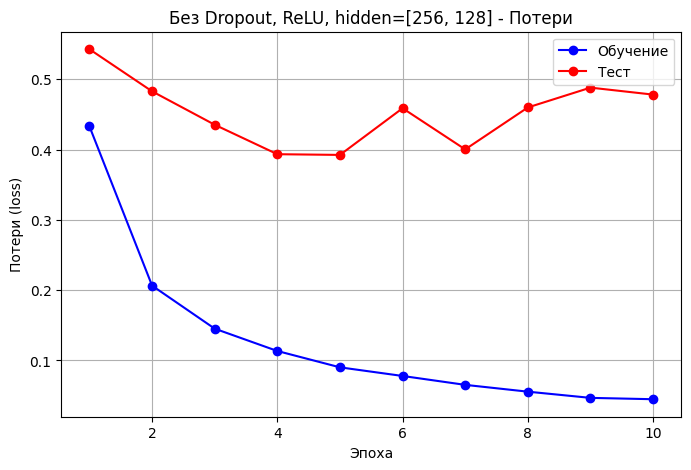

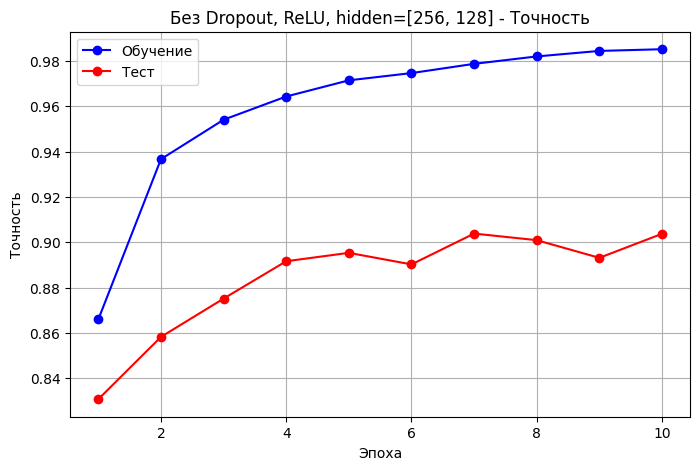

F1-мера для Без Dropout, ReLU, hidden=[256, 128]: 0.9039

--- Эксперимент: С Dropout(0.5), ReLU, hidden=[256, 128] ---
Эпоха 1/10: Train loss=0.7655, Train acc=0.7584 | Test loss=0.7053, Test acc=0.7789
Эпоха 2/10: Train loss=0.4899, Train acc=0.8520 | Test loss=0.6093, Test acc=0.8064
Эпоха 3/10: Train loss=0.4240, Train acc=0.8709 | Test loss=0.5463, Test acc=0.8316
Эпоха 4/10: Train loss=0.3947, Train acc=0.8811 | Test loss=0.5102, Test acc=0.8442
Эпоха 5/10: Train loss=0.3664, Train acc=0.8888 | Test loss=0.4934, Test acc=0.8515
Эпоха 6/10: Train loss=0.3536, Train acc=0.8934 | Test loss=0.4849, Test acc=0.8539
Эпоха 7/10: Train loss=0.3367, Train acc=0.8961 | Test loss=0.5180, Test acc=0.8425
Эпоха 8/10: Train loss=0.3238, Train acc=0.9019 | Test loss=0.4656, Test acc=0.8640
Эпоха 9/10: Train loss=0.3127, Train acc=0.9038 | Test loss=0.4786, Test acc=0.8556
Эпоха 10/10: Train loss=0.3081, Train acc=0.9074 | Test loss=0.4688, Test acc=0.8564


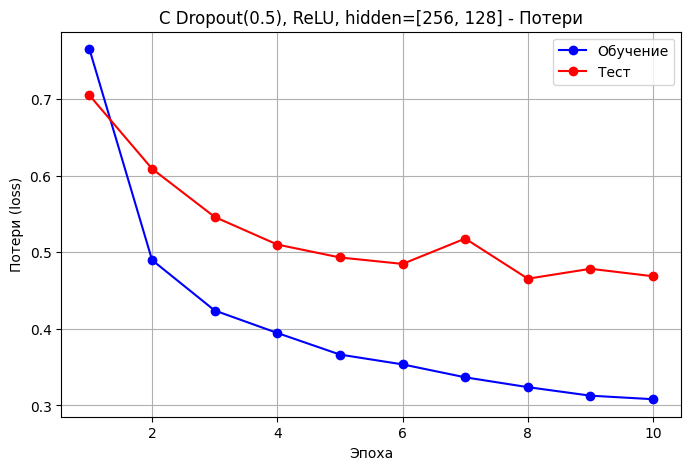

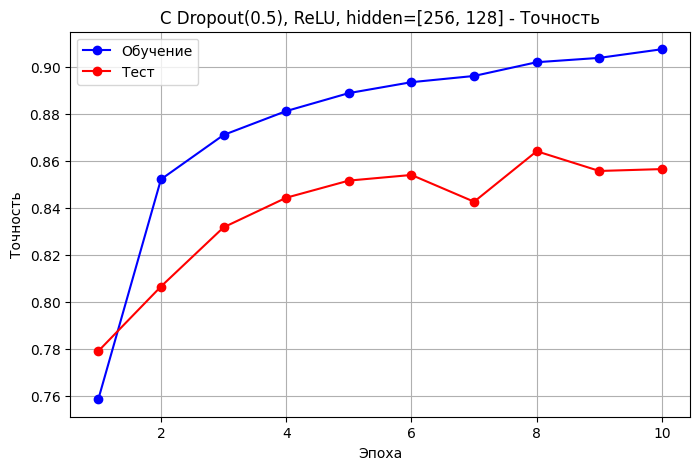

F1-мера для С Dropout(0.5), ReLU, hidden=[256, 128]: 0.8567

--- Эксперимент: Без Dropout, Sigmoid, hidden=[256, 128] ---
Эпоха 1/10: Train loss=0.6901, Train acc=0.7990 | Test loss=0.6674, Test acc=0.7882
Эпоха 2/10: Train loss=0.2915, Train acc=0.9121 | Test loss=0.5145, Test acc=0.8419
Эпоха 3/10: Train loss=0.2026, Train acc=0.9400 | Test loss=0.5256, Test acc=0.8384
Эпоха 4/10: Train loss=0.1542, Train acc=0.9549 | Test loss=0.4304, Test acc=0.8741
Эпоха 5/10: Train loss=0.1192, Train acc=0.9648 | Test loss=0.4442, Test acc=0.8754
Эпоха 6/10: Train loss=0.0948, Train acc=0.9725 | Test loss=0.4535, Test acc=0.8723
Эпоха 7/10: Train loss=0.0768, Train acc=0.9776 | Test loss=0.4530, Test acc=0.8752
Эпоха 8/10: Train loss=0.0652, Train acc=0.9810 | Test loss=0.4999, Test acc=0.8700
Эпоха 9/10: Train loss=0.0546, Train acc=0.9840 | Test loss=0.4838, Test acc=0.8837
Эпоха 10/10: Train loss=0.0453, Train acc=0.9868 | Test loss=0.4815, Test acc=0.8822


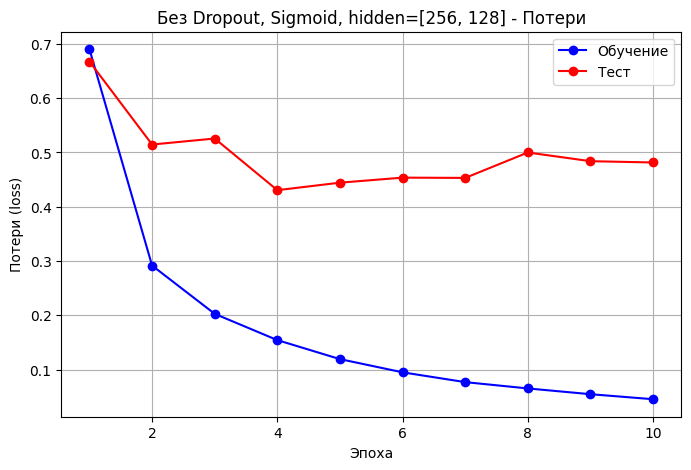

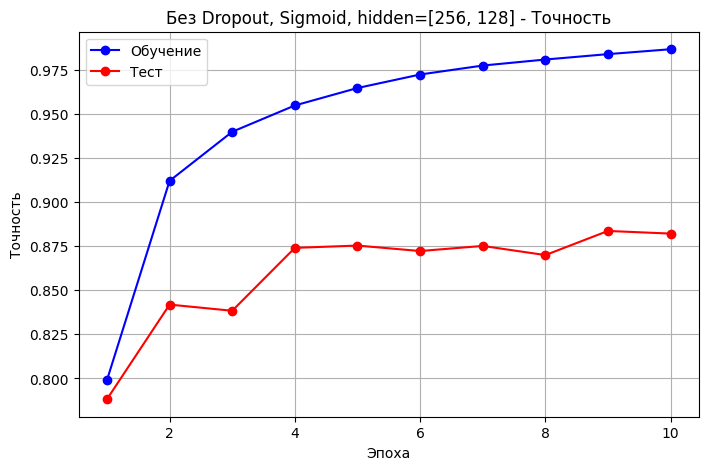

F1-мера для Без Dropout, Sigmoid, hidden=[256, 128]: 0.8826

--- Эксперимент: Без Dropout, Tanh, hidden=[256, 128] ---
Эпоха 1/10: Train loss=0.4647, Train acc=0.8578 | Test loss=0.5690, Test acc=0.8217
Эпоха 2/10: Train loss=0.2322, Train acc=0.9291 | Test loss=0.5122, Test acc=0.8459
Эпоха 3/10: Train loss=0.1751, Train acc=0.9469 | Test loss=0.4639, Test acc=0.8652
Эпоха 4/10: Train loss=0.1487, Train acc=0.9532 | Test loss=0.4726, Test acc=0.8612
Эпоха 5/10: Train loss=0.1242, Train acc=0.9611 | Test loss=0.5742, Test acc=0.8453
Эпоха 6/10: Train loss=0.1116, Train acc=0.9641 | Test loss=0.4848, Test acc=0.8677
Эпоха 7/10: Train loss=0.0962, Train acc=0.9701 | Test loss=0.4620, Test acc=0.8759
Эпоха 8/10: Train loss=0.0891, Train acc=0.9715 | Test loss=0.5080, Test acc=0.8672
Эпоха 9/10: Train loss=0.0872, Train acc=0.9726 | Test loss=0.4514, Test acc=0.8839
Эпоха 10/10: Train loss=0.0758, Train acc=0.9759 | Test loss=0.5073, Test acc=0.8764


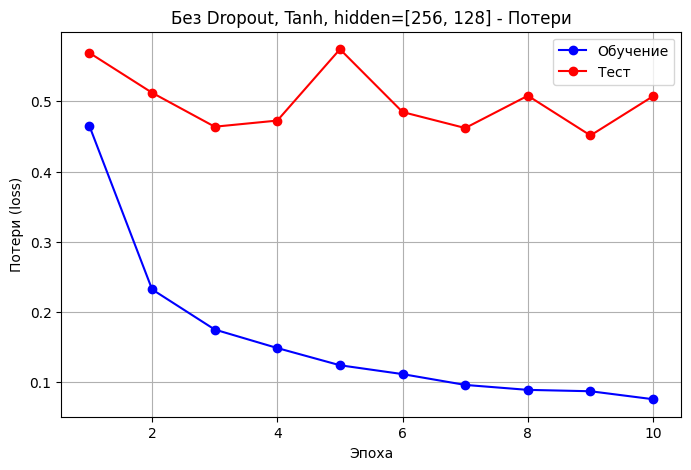

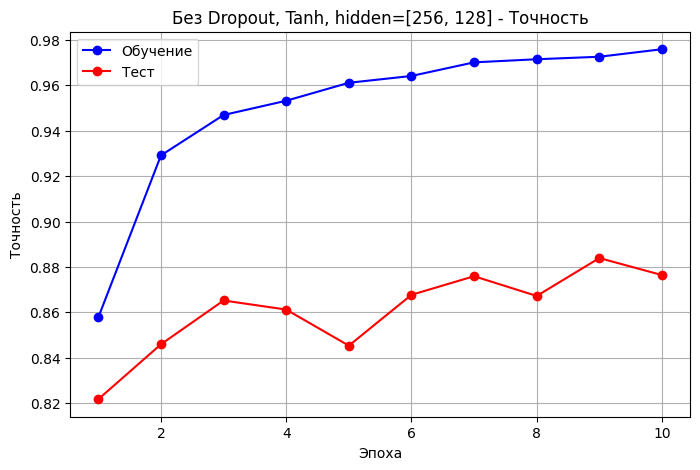

F1-мера для Без Dropout, Tanh, hidden=[256, 128]: 0.8766


In [12]:
# Словари для хранения метрик по экспериментам
exp_histories = {}

for exp in experiments:
    print(f"\n--- Эксперимент: {exp['name']} ---")
    model = FCNN(input_dim=28*28, hidden_dims=exp["hidden_dims"], output_dim=10,
                  activation=exp["activation"], dropout_prob=exp["dropout"]).to(device)
    criterion_kmnist = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses_exp, train_accuracies_exp = [], []
    test_losses_exp, test_accuracies_exp = [], []

    for epoch in range(num_epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader_kmnist, criterion_kmnist, optimizer, device)
        test_loss, test_acc = evaluate(model, test_loader_kmnist, criterion_kmnist, device)
        train_losses_exp.append(train_loss)
        train_accuracies_exp.append(train_acc)
        test_losses_exp.append(test_loss)
        test_accuracies_exp.append(test_acc)
        print(f"Эпоха {epoch+1}/{num_epochs}: Train loss={train_loss:.4f}, Train acc={train_acc:.4f} | Test loss={test_loss:.4f}, Test acc={test_acc:.4f}")

    exp_histories[exp["name"]] = {
        "train_losses": train_losses_exp,
        "train_acc": train_accuracies_exp,
        "test_losses": test_losses_exp,
        "test_acc": test_accuracies_exp,
        "model": model  # сохраняем модель для дальнейшей оценки
    }

    # Построение графиков для текущего эксперимента
    plot_metrics(train_losses_exp, test_losses_exp, ylabel="Потери (loss)", title=f"{exp['name']} - Потери")
    plot_metrics(train_accuracies_exp, test_accuracies_exp, ylabel="Точность", title=f"{exp['name']} - Точность")

    # Оценка F1-меры на тестовой выборке
    _, _, preds, labels = evaluate(model, test_loader_kmnist, criterion_kmnist, device, return_preds=True)
    f1 = f1_score(labels, preds, average='macro')
    print(f"F1-мера для {exp['name']}: {f1:.4f}")

In [13]:
# Сравнительный анализ – можно вывести сводную таблицу по последней эпохе каждого эксперимента
print("\nСравнительный анализ на KMNIST (последняя эпоха):")
for exp_name, history in exp_histories.items():
    final_train_acc = history["train_acc"][-1]
    final_test_acc = history["test_acc"][-1]
    _, _, preds, labels = evaluate(history["model"], test_loader_kmnist, criterion, device, return_preds=True)
    f1 = f1_score(labels, preds, average='macro')
    print(f"{exp_name}: Train Acc={final_train_acc:.4f}, Test Acc={final_test_acc:.4f}, F1={f1:.4f}")


Сравнительный анализ на KMNIST (последняя эпоха):
Без Dropout, ReLU, hidden=[256, 128]: Train Acc=0.9852, Test Acc=0.9037, F1=0.9039
С Dropout(0.5), ReLU, hidden=[256, 128]: Train Acc=0.9074, Test Acc=0.8564, F1=0.8567
Без Dropout, Sigmoid, hidden=[256, 128]: Train Acc=0.9868, Test Acc=0.8822, F1=0.8826
Без Dropout, Tanh, hidden=[256, 128]: Train Acc=0.9759, Test Acc=0.8764, F1=0.8766
